<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/face_recognition_pca_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'retina'

In [ ]:
#Loading faces dataset
df = fetch_lfw_people(min_faces_per_person = 50)

In [ ]:
#Extra data
faces = df['data']
labels = df['target']
names = df['target_names']

print(f'Faces images shape: {faces.shape}')
print(f'Targets images shape: {labels.shape}')
print(f'Target names: {names}, Total names: {len(names)}')

Faces images shape: (1560, 2914)
Targets images shape: (1560,)
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair'], Total names: 12


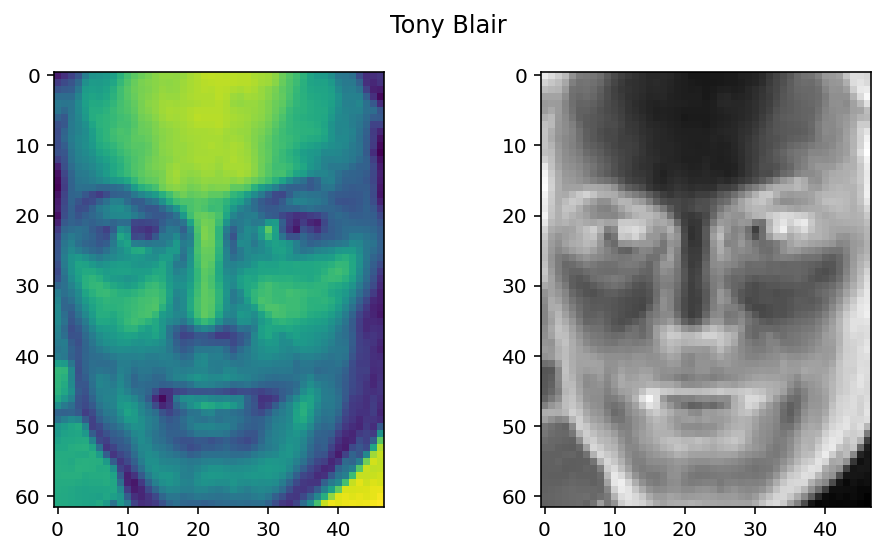

In [ ]:
#Show example image
randomFace = np.random.choice(faces.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.suptitle(names[labels[randomFace]][0])
ax[0].imshow(faces[randomFace].reshape(62, -1)) #Images size (62 x 47)
ax[1].imshow(faces[randomFace].reshape(62, -1), cmap = plt.cm.binary)
plt.show()

In [ ]:
#Train test splits
trainX, testX, trainY, testY = train_test_split(faces, labels, test_size = 0.2, random_state = 777)

print(f'Training images shape: {trainX.shape}')
print(f'Training labels shape: {trainY.shape}')
print(f'Testing images shape: {testX.shape}')
print(f'Testing labels shape: {testY.shape}')

Training images shape: (1248, 2914)
Training labels shape: (1248,)
Testing images shape: (312, 2914)
Testing labels shape: (312,)


In [ ]:
#Standard scaler (Z-Score)
scaler = StandardScaler()
scaler.fit(trainX)
trainXstandard = scaler.transform(trainX)
testXstandard = scaler.transform(testX) #Using scaler from trainX

In [ ]:
#PCA
pca = PCA(n_components = min(trainXstandard.shape[0], trainXstandard.shape[1])) #Min between samples and features
pca.fit(trainXstandard) #Fitting PCA
trainXpca = pca.transform(trainXstandard) #Decomposed trainX

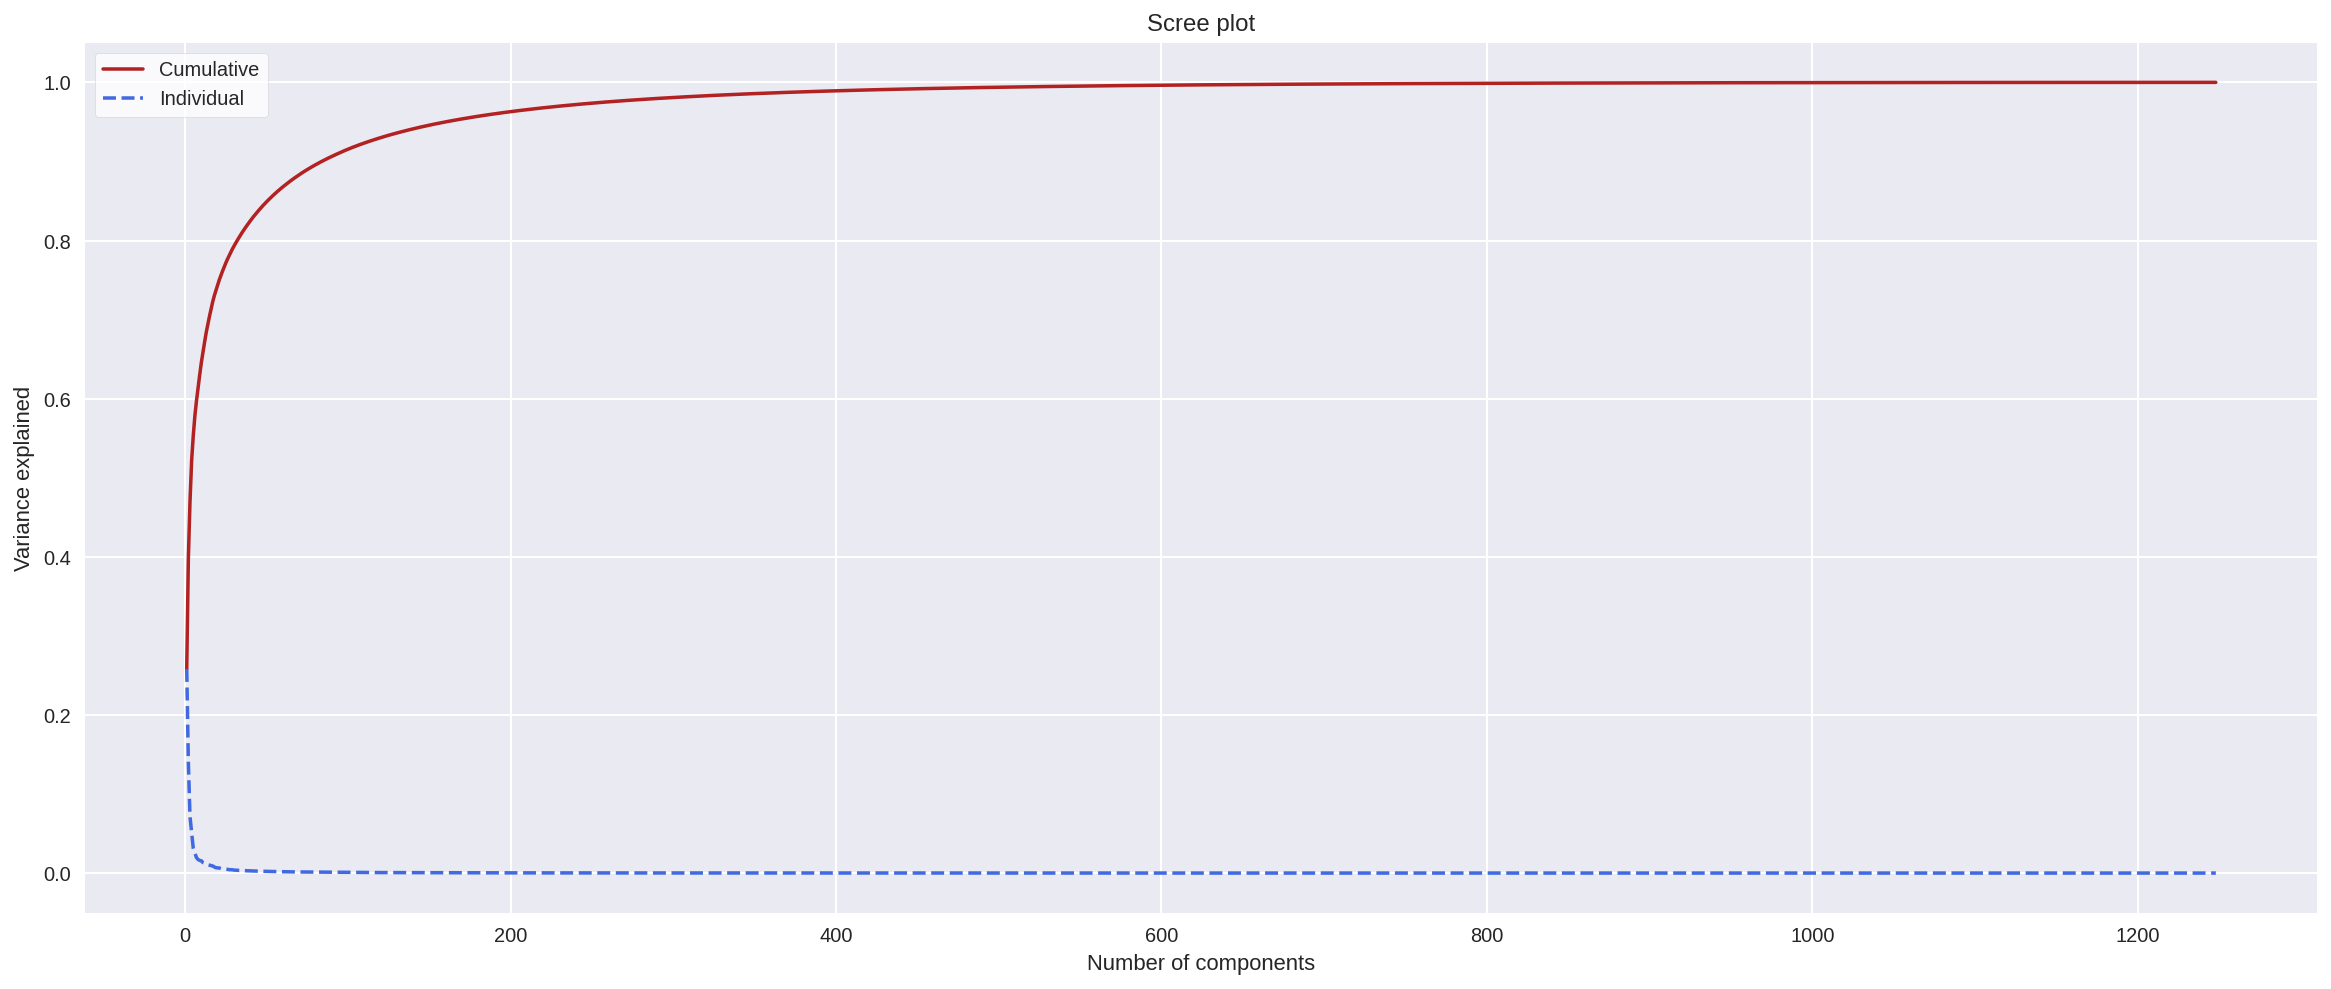

In [ ]:
#Scree plot
explainRatio = pca.explained_variance_ratio_
explainRationCum = np.cumsum(pca.explained_variance_ratio_)

#Create scree plot
plt.figure(figsize = (20, 8))
with plt.style.context('seaborn'):
  plt.title('Scree plot')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.plot(range(1, explainRatio.shape[0] + 1), explainRationCum, c = 'firebrick', label = 'Cumulative')
  plt.plot(range(1, explainRatio.shape[0] + 1), explainRatio, c = 'royalblue', linestyle = '--', label = 'Individual')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

In [ ]:
#Fittin PCA by percentages
pca = PCA(n_components = 0.95) #Input explain percentages
pca.fit(trainXstandard)
trainXpca = pca.transform(trainXstandard) #Decomposed trainX

print(f'Number of components: {pca.n_components_}')
print(f'Training image decomposed shape: {trainXpca.shape}')

Number of components: 160
Training image decomposed shape: (1248, 160)


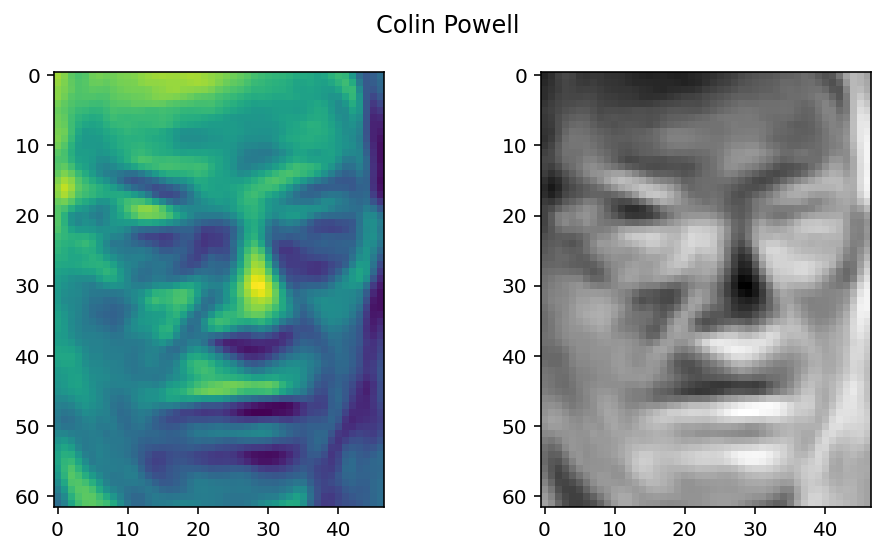

In [ ]:
#Show decomposed image
trainXdecom = np.dot(trainXpca, pca.components_)
randomFace = np.random.choice(trainXdecom.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.suptitle(names[trainY[randomFace]][0])
ax[0].imshow(trainXdecom[randomFace].reshape(62, -1))
ax[1].imshow(trainXdecom[randomFace].reshape(62, -1), cmap = plt.cm.binary)
plt.show()

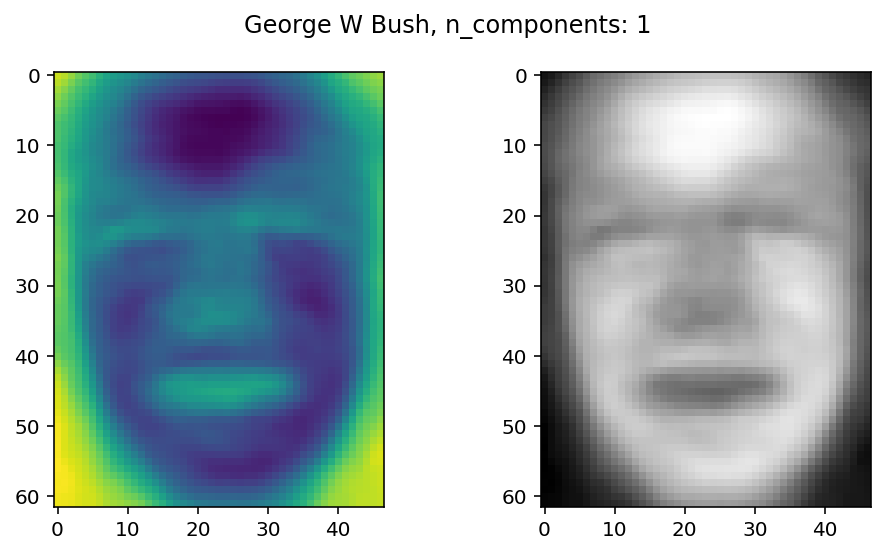

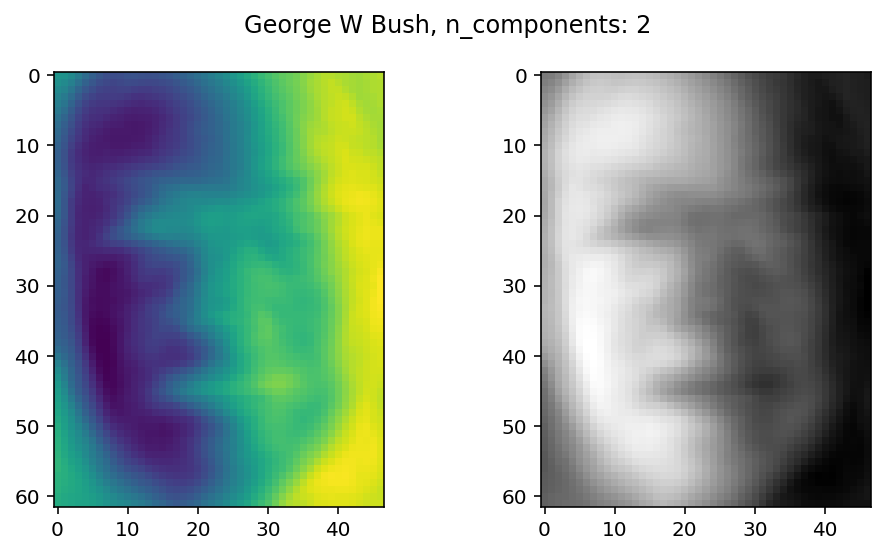

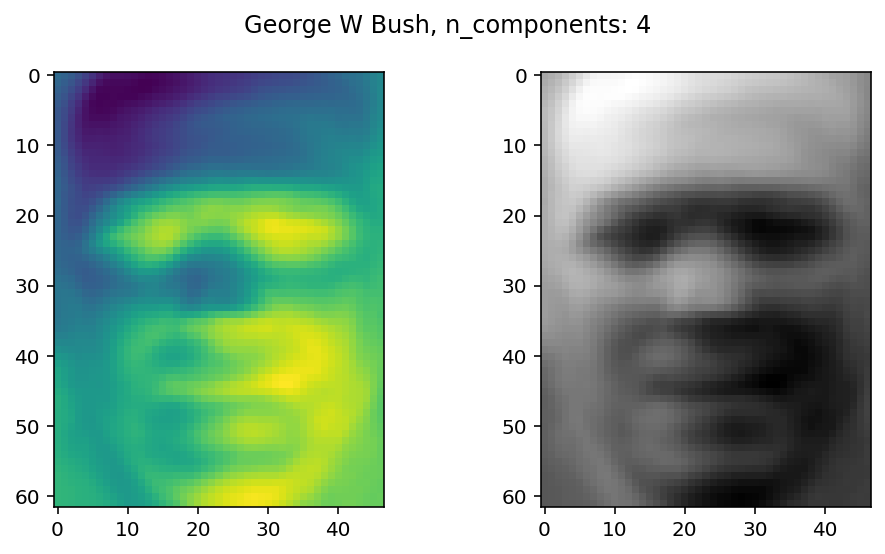

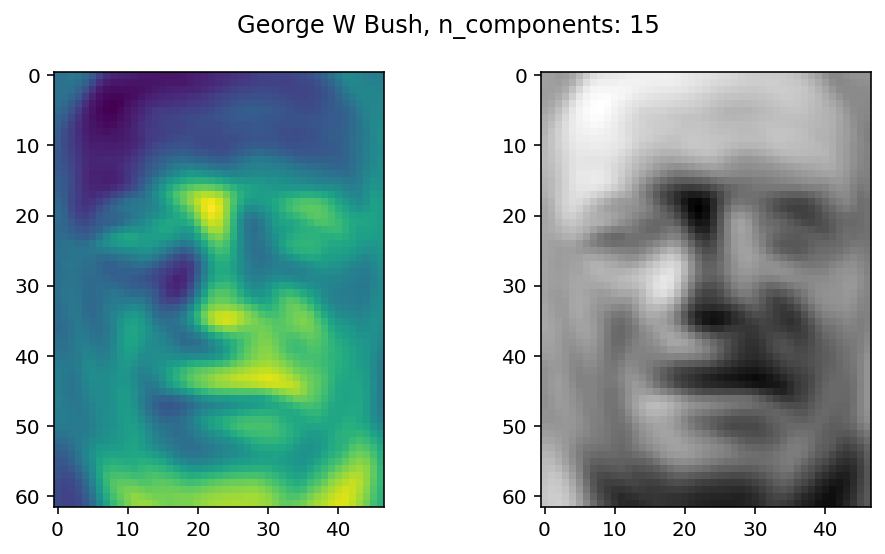

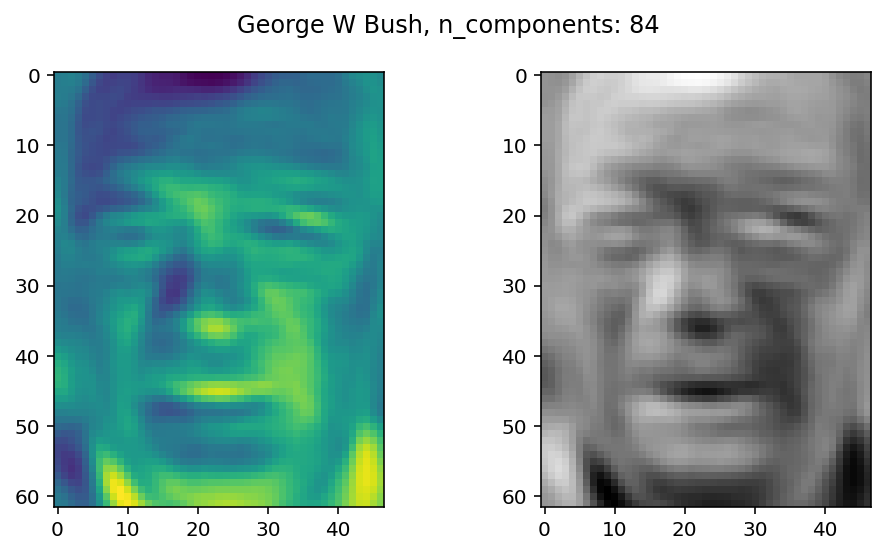

In [ ]:
#Difference decomposed values
nComponents = np.arange(0.1, 1.0, 0.2)
randomFace = np.random.choice(trainXstandard.shape[0], 1)

for n in nComponents:
  pca = PCA(n_components = n)
  pca.fit(trainXstandard)
  trainXpca = pca.transform(trainXstandard)
  trainXdecom = np.dot(trainXpca, pca.components_)
  fig, ax = plt.subplots(1, 2, figsize = (8, 4))
  fig.suptitle(f'{names[trainY[randomFace]][0]}, n_components: {pca.n_components_}')
  ax[0].imshow(trainXdecom[randomFace].reshape(62, -1)) #Images size (62 x 47)
  ax[1].imshow(trainXdecom[randomFace].reshape(62, -1), cmap = plt.cm.binary)
  plt.show()

In [ ]:
#Fittin PCA at 95% for classification model
pca = PCA(n_components = 0.95)
pca.fit(trainXstandard)
trainXpca = pca.transform(trainXstandard)
testXpca = pca.transform(testXstandard) #Use transformer from trainX

In [ ]:
#SVM using Support Vector Classifier
clf = SVC(kernel = 'rbf')
clf.fit(trainXpca, trainY)
print(f'Train score: {clf.score(trainXpca, trainY) * 100:.2f}%')
print(f'Test score: {clf.score(testXpca, testY) * 100:.2f}%')

Train score: 93.59%
Test score: 73.08%


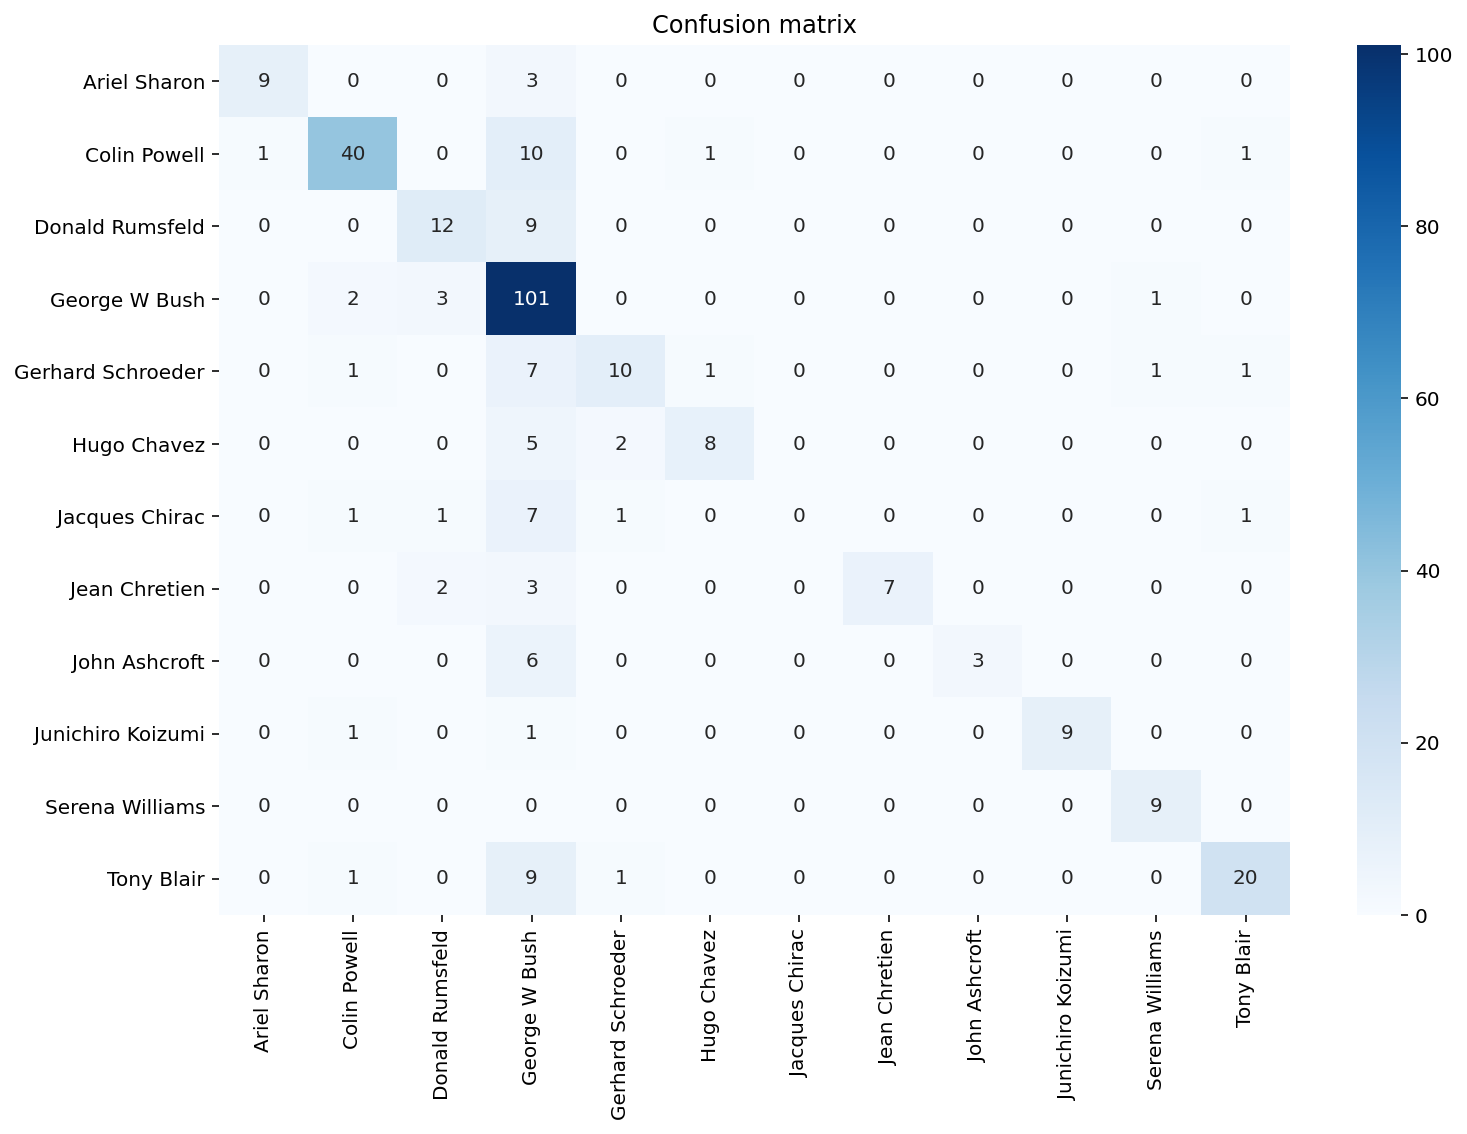

In [ ]:
#Model prediction
predY = clf.predict(testXpca)

#Confusion matrix
cf_matrix = confusion_matrix(testY, predY)
plt.figure(figsize = (12, 8))
plt.title('Confusion matrix')
sns.heatmap(cf_matrix, xticklabels = names, yticklabels = names, annot = True, fmt = '.0f', cmap = plt.cm.Blues)
plt.show()

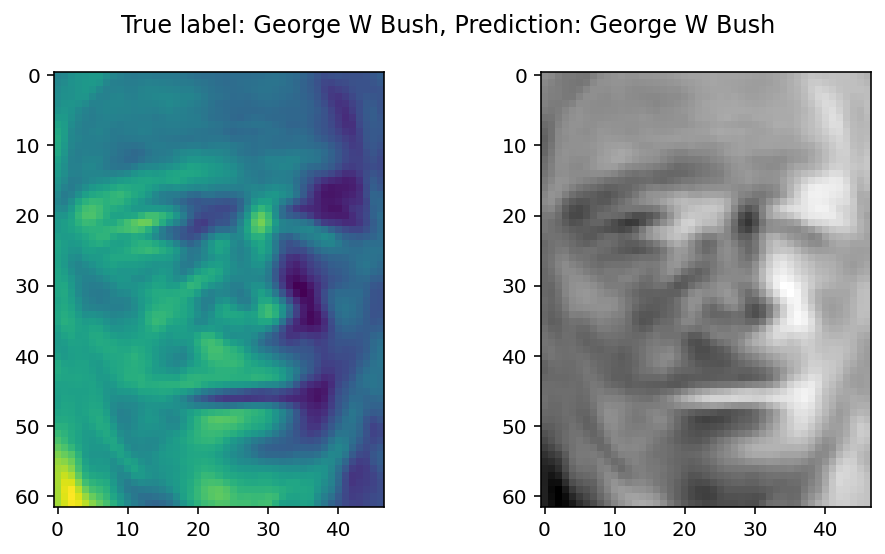

In [ ]:
#Model used test
testXdecom = np.dot(testXpca, pca.components_)
randomFace = np.random.choice(testXdecom.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.suptitle(f'True label: {names[testY[randomFace]][0]}, Prediction: {names[predY[randomFace]][0]}')
ax[0].imshow(testXdecom[randomFace].reshape(62, -1))
ax[1].imshow(testXdecom[randomFace].reshape(62, -1), cmap = plt.cm.binary)
plt.show()

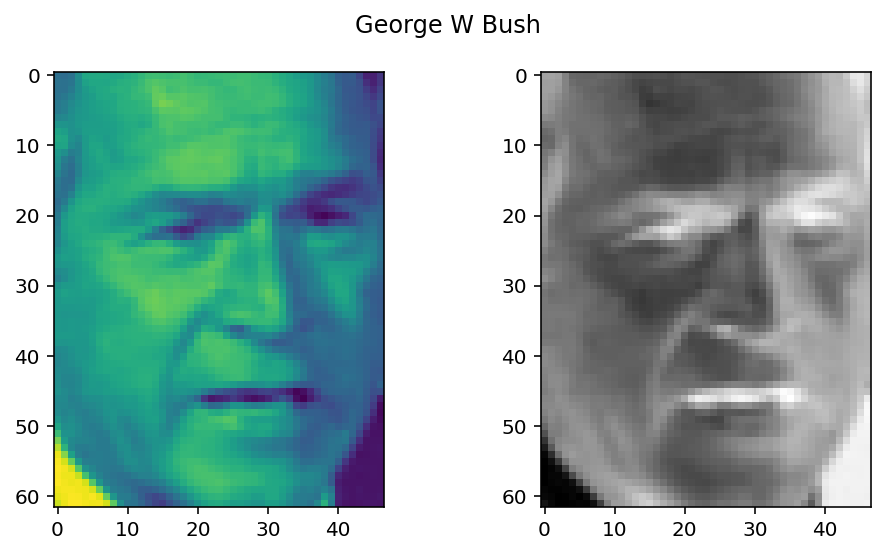

In [ ]:
#Actual image
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.suptitle(names[testY[randomFace]][0])
ax[0].imshow(testX[randomFace].reshape(62, -1))
ax[1].imshow(testX[randomFace].reshape(62, -1), cmap = plt.cm.binary)
plt.show()